In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import Distance
from astropy.cosmology import Planck18_arXiv_v2
from frbpoppy import CosmicPopulation, Survey, SurveyPopulation, plot
from virgodb import VirgoDB

In [3]:
# Generate the desired number of FRBs.
frbs = pd.DataFrame()
n_frbs = 100
while frbs.shape[0] < n_frbs:
    # Generate an observed FRB population
    cosmic_pop = CosmicPopulation(5e5, name='cosmic', days=1)
    survey = Survey('askap-incoh')
    survey_pop = SurveyPopulation(cosmic_pop, survey, rate_limit=False)
    
    frbs = frbs.append(survey_pop.to_df())

print(frbs.shape[0])
# Check the detection rates
#print(survey_pop.rates())

# Plot populations in a browser
#plot(cosmic_pop, survey_pop, frbcat='parkes')

cosmic_pop.py | Generating cosmic population
cosmic_pop.py | Finished generating cosmic population
survey_pop.py | Surveying cosmic with askap-incoh
cosmic_pop.py | Generating cosmic population
cosmic_pop.py | Finished generating cosmic population
survey_pop.py | Surveying cosmic with askap-incoh
191


In [4]:
frbs = frbs.iloc[:n_frbs]

# Make bins around the catalog snapshots
vdb = VirgoDB(username='', password='')
snapshots = vdb.execute_query('select * from Snapshots..MR7')
snapshots = snapshots[::-1]
snap_zs = snapshots['z']
bins = np.concatenate((snap_zs[0:1], snap_zs[:-1] + np.diff(snap_zs), snap_zs[-1:] + 50.))
nums_to_draw = np.histogram(frbs['z'], bins=bins)[0]

snapnum = snapshots['snapnum']
relev_snap = nums_to_draw != 0

In [4]:
# Draw galaxies for each non-zero bin.
galaxies = pd.DataFrame()
for snap, n_draw in zip(snapnum[relev_snap], nums_to_draw[relev_snap]):
    # Get a (hopefully) representative sample.
    galaxy_pop = vdb.execute_query(f'select top 1000000 GalaxyID, stellarmass, sfr '
                                   f'from Lacey2016a..MR7 '
                                   f'where snapnum = {snap} ')
    
    # Draw the desired number of galaxies from the sample.
    rng = np.random.default_rng(seed=42)
    drawn_galaxies = rng.choice(galaxy_pop['GalaxyID'], size=n_draw, p=galaxy_pop['sfr']/galaxy_pop['sfr'].sum())
    
    # Query full information for selected galaxies.
    galaxy_info = vdb.execute_query(f'select * '
                                    f'from Lacey2016a..MR7 '
                                    f'where snapnum = {snap} '
                                    f'and GalaxyID in ({str(list(drawn_galaxies))[1:-1]}) ')
    galaxies = galaxies.append(pd.DataFrame.from_records(galaxy_info, index='GalaxyID'))

In [5]:
# Test if the galaxies would be observable in DES Y1A1 GOLD.
# From https://iopscience.iop.org/article/10.3847/1538-4365/aab4f5/pdf
# "The 10σ limiting magnitude for galaxies is g=23.4, r=23.2, i=22.5, z=21.8, and Y=20.1."
dist = Distance(z=galaxies['Redshift'], cosmology=Planck18_arXiv_v2)
apparent_mag = dist.distmod.value[:, np.newaxis] + galaxies.loc[:, 'DES_g_obs_ext':'DES_Y_obs_ext':4]
mag_limits = np.array([23.4, 23.2, 22.5, 21.8, 20.1])
n_bands_obs = (apparent_mag < mag_limits).sum(axis=1)

In [43]:
# Test if the galaxies would be observable in EUCLIC.
# Limits taken from https://sci.esa.int/web/euclid/-/euclid-vis-instrument
apparent_mag = dist.distmod.value[:, np.newaxis] + galaxies.loc[:, 'EUCLID_V_obs_ext':'EUCLID_H_obs_ext':4]
mag_limits = np.array([25., 24., 24., 24.])
n_bands_obs = (apparent_mag < mag_limits).sum(axis=1)

In [48]:
# Test if the galaxies would be observable in SDSS DR16.
# Limits taken from https://www.sdss.org/dr16/scope/
apparent_mag = dist.distmod.value[:, np.newaxis] + galaxies.loc[:, 'SDSS_u_obs_ext':'SDSS_z_obs_ext':4]
mag_limits = np.array([22.0, 22.2, 22.2, 21.3, 20.5])
n_bands_obs = (apparent_mag < mag_limits).sum(axis=1)

Text(0.5, 1.0, 'SDSS')

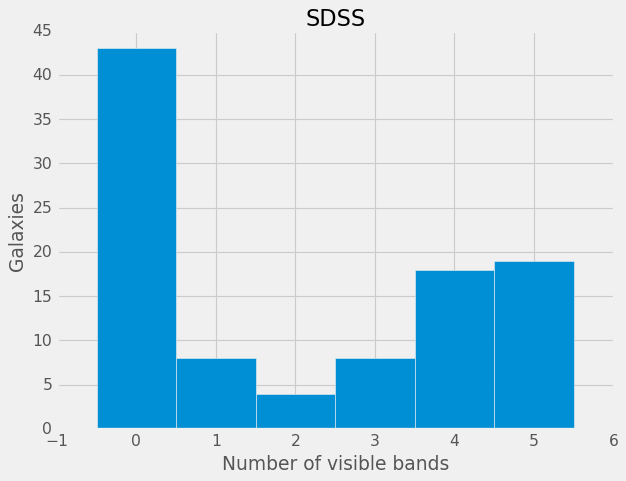

In [62]:
plt.style.use('fivethirtyeight')

plt.hist(n_bands_obs, bins=np.linspace(-.5, 5.5, 7))
plt.xlabel('Number of visible bands')
plt.ylabel('Galaxies')
plt.title('SDSS')

In [54]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [9]:
galaxies['Redshift'].head(20)

GalaxyID
700007480000001     0.019933
1200297510000001    0.019933
1200298390000002    0.041403
1200301090000003    0.064493
700033080000004     0.089288
1200305730000004    0.089288
700039250000005     0.115883
1100257490000005    0.115883
1200306950000005    0.115883
1300370080000005    0.115883
700045780000006     0.144383
1200308580000006    0.144383
700050680000007     0.174898
1100264490000079    0.174898
1200313310000007    0.174898
1300387550000007    0.174898
100257190000008     0.207549
200011190000008     0.207549
500503130000008     0.207549
700052150000008     0.207549
Name: Redshift, dtype: float32

In [10]:
frbs

,ra,dec,dist_co,gb,gl,gx,gy,gz,z,dm,...,w_int,fluence,offset,s_peak,snr,t_dm,T_sky,T_sys,w_eff,index
0,263.375368,-10.554502,1.226772,13.075248,14.645961,0.232657,-0.890246,0.213707,0.29866,679.821442,...,2.958526,37.159198,2.144015,7.855287,14.179436,2.452598,3.424224,73.424225,4.730470,442
1,153.364609,10.948592,0.914796,48.469821,-131.198474,-0.374662,0.327982,0.562215,0.21808,387.478611,...,1.893472,17.340007,2.270304,5.820937,8.453563,1.397910,0.708460,70.708458,2.978903,3413
2,350.473460,37.366990,1.020318,-21.792643,103.862113,0.738842,0.182335,-0.304268,0.24493,669.778633,...,1.451209,44.268359,1.304038,13.531303,17.248266,2.416367,1.298844,71.298843,3.271552,5816
3,189.689323,3.039263,1.043723,65.542587,-66.781047,-0.317457,-0.136178,0.759484,0.25094,469.379725,...,2.837286,25.430868,1.349464,6.156111,10.998781,1.693386,1.298844,71.298843,4.130996,7822
4,46.134771,-32.170260,0.857038,-61.821624,-127.978313,-0.265057,0.206932,-0.627696,0.20355,319.489618,...,1.972921,206.100892,0.662051,70.414780,103.676949,1.152626,0.765137,70.765137,2.926955,12937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,243.777462,-27.002269,0.834254,17.830016,-10.549620,-0.121388,-0.651792,0.213252,0.19785,507.006142,...,0.553622,25.672395,1.343302,11.062276,8.424889,1.829131,2.300134,72.300133,2.320716,453182
96,6.920543,-70.390453,0.511913,-46.541852,-52.567329,-0.249858,-0.191249,-0.332064,0.11902,296.434887,...,1.671845,41.852151,1.200280,16.748974,21.768944,1.069451,1.157152,71.157150,2.498789,459375
97,303.803277,-22.944163,0.976846,-26.997369,20.601564,0.248224,-0.660326,-0.359403,0.23382,471.492729,...,1.234910,30.067957,2.480292,11.517682,13.496115,1.701009,1.227998,71.227997,2.610591,459823
98,177.388497,-38.028321,1.869319,22.985467,-70.319449,-1.096731,-0.392258,0.494067,0.47746,658.126427,...,2.122865,20.223416,1.507457,4.894120,8.256458,2.374329,0.982398,70.982399,4.132187,460168
